<a href="https://colab.research.google.com/github/sachinprasadhs/AI-Concepts/blob/main/Common%20Concepts/Linear%20Regression/linear_regression_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.kaggle.com/code/sravanneeli/linear-regression-from-scratch-jax?scriptVersionId=174582824" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Linear Regression
**Assumptions**

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/sachinprasadhs/AI-Concepts/blob/master/Common%20Concepts/Linear%20Regression/linear_regression_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Import Necessary Libraries

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm

import warnings
warnings.filterwarnings('ignore')

# Generate Random Dataset

In [ ]:
seed = 32
num_samples = 100000
num_features = 5

# New JAX PRNG API (recommended)
key = jax.random.key(seed)

In [ ]:
# Split keys for different random operations - JAX requires unique keys!
key, coeff_key, X_key, bias_key, noise_key = jax.random.split(key, 5)

random_coeff = jax.random.randint(coeff_key, shape=[num_features], minval=-10, maxval=10)

X = 2 * jax.random.normal(X_key, shape=(num_samples, num_features))

# Generate Random Bias and Coefficients
random_bais = jax.random.choice(bias_key, random_coeff, shape=(1,))
random_coeff = jax.random.choice(coeff_key, random_coeff, shape=(num_features,))

print(f"Random Bias: {random_bais}")
print(f"Random Coefficients: {random_coeff}")

coeff_features = []

# Construct each feature with random coeffcients choosen
for idx, coeff in enumerate(random_coeff):
  coeff_features.append(coeff * X[:, idx:idx+1])

# Print equation
equation = f"Y = {random_bais[0]}"
for idx, coeff in enumerate(random_coeff):
  equation += f" + {coeff} * X{idx+1}"
print(equation)


# Stack the features into a single matrix
coeff_features = jnp.hstack(coeff_features)

# Generate output from random data with unique noise key
y = random_bais + jnp.sum(coeff_features, axis=1) + jax.random.normal(noise_key, shape=(num_samples,))

Random Bias: [-8]
Random Coefficients: [ 5  5 -8 -2 -8]
Y = -8 + 5 * X1 + 5 * X2 + -8 * X3 + -2 * X4 + -8 * X5


# Normal Equation

$$\theta = (X^TX)^{-1} X^Ty$$

* Computes the inverse of $X^T X$ with complexity $O(n^{2.4})$ to $O(n^3)$
* May not be invertible if columns are linearly dependent — use pseudoinverse
* Slow for large features (100,000+), but scales linearly with samples $O(m)$

### Using `jax.jit`

`jax.jit` compiles functions to XLA (Accelerated Linear Algebra) for optimized execution:
- **Fusion:** Multiple ops → single kernel (less memory transfer)
- **Caching:** First call compiles, subsequent calls are fast
- **Hardware:** Works on CPU, GPU, TPU

In [ ]:
import time
from functools import partial

class NormFit:
  """
  A class for fitting and predicting using the normal equation.
  Supports both JIT-compiled and non-JIT versions for performance comparison.

  Attributes:
      theta (numpy.ndarray): The parameters of the linear regression model.
      use_jit (bool): Whether to use JIT compilation.
  """

  def __init__(self, use_jit: bool = True):
    """
    Initialize the NormFit class with theta set to None.

    Args:
        use_jit (bool): If True, use JIT-compiled methods. Default True.
    """
    self.theta = None
    self.use_jit = use_jit

  @staticmethod
  def _fit_impl(X: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """Core fitting logic - can be JIT compiled."""
    X_b = jnp.hstack((jnp.ones((X.shape[0], 1)), X))  # Add a column of ones for the bias term
    theta = jnp.linalg.pinv(X_b) @ y  # Use pinv for better numerical stability
    return theta

  # JIT-compiled version
  _fit_jit = staticmethod(jax.jit(_fit_impl.__func__))

  @staticmethod
  def _predict_impl(X: jnp.ndarray, theta: jnp.ndarray) -> jnp.ndarray:
    """Core prediction logic - can be JIT compiled."""
    return X @ theta

  # JIT-compiled version
  _predict_jit = staticmethod(jax.jit(_predict_impl.__func__))

  def fit(self, X: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """
    Fit the linear regression model using the normal equation.

    Args:
        X (numpy.ndarray): The input features.
        y (numpy.ndarray): The target values.

    Returns:
        numpy.ndarray: The learned parameters (theta).
    """
    if self.use_jit:
      self.theta = self._fit_jit(X, y)
    else:
      self.theta = self._fit_impl(X, y)
    return self.theta

  def predict(self, X: jnp.ndarray) -> jnp.ndarray:
    """
    Predict the target values using the learned model.

    Args:
        X (numpy.ndarray): The input features.

    Returns:
        numpy.ndarray: The predicted target values.
    """
    # Add bias column for prediction
    X_b = jnp.hstack((jnp.ones((X.shape[0], 1)), X))
    if self.use_jit:
      return self._predict_jit(X_b, self.theta)
    else:
      return self._predict_impl(X_b, self.theta)

## Performance Comparison: JIT vs Non-JIT

Let's compare the performance of JIT-compiled vs non-JIT versions of the Normal Equation.

In [ ]:
# Performance comparison: JIT vs Non-JIT
def benchmark_normfit(X, y, use_jit, num_runs=5):
    """Benchmark NormFit with or without JIT."""
    model = NormFit(use_jit=use_jit)

    # Warm-up run (important for JIT to compile)
    _ = model.fit(X, y)

    # Timed runs
    times = []
    for _ in range(num_runs):
        start = time.perf_counter()
        _ = model.fit(X, y)
        end = time.perf_counter()
        times.append(end - start)

    return np.mean(times), np.std(times)

# Benchmark with JIT
jit_mean, jit_std = benchmark_normfit(X, y, use_jit=True)
print(f"JIT-compiled:     {jit_mean*1000:.4f} ± {jit_std*1000:.4f} ms")

# Benchmark without JIT
no_jit_mean, no_jit_std = benchmark_normfit(X, y, use_jit=False)
print(f"Non-JIT:          {no_jit_mean*1000:.4f} ± {no_jit_std*1000:.4f} ms")

# Speedup
speedup = no_jit_mean / jit_mean
print(f"\nSpeedup: {speedup:.2f}x faster with JIT")

JIT-compiled:     0.4926 ± 0.0223 ms
Non-JIT:          1.8181 ± 0.1614 ms

Speedup: 3.69x faster with JIT


## Fit Normal Equation to Data to get Weights/Coefficients

In [ ]:
normfit = NormFit()
theta = normfit.fit(X, y)

predicted_eq = f"Y_ = {jnp.round(theta[0], 1)}"
for idx, coeff in enumerate(theta[1:]):
  predicted_eq += f" + {jnp.round(coeff, 1)} * X{idx+1}"

print(predicted_eq)

Y_ = -8.0 + 5.0 * X1 + 5.0 * X2 + -8.0 * X3 + -2.0 * X4 + -8.0 * X5


# Gradient Descent Training


* Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.
* Suppose you are lost in the mountains in a dense fog; you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope.
* This is exactly what Gradient Descent does: **it measures the local gradient of the error function with regards to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!**
* An important parameter in Gradient Descent is the size of the steps, determined by the `learning rate` hyperparameter.
  * If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
  * On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution


## Linear Regression Gradient Descent

$$ MSE(\theta) = \dfrac{1}{m} * \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{i})^{2}$$

$$ \nabla_\theta MSE(\theta) = \dfrac{2}{m}X^{T}(X\theta - y)$$

$$ \theta^{(next \, step)} = \theta - 𝞰\nabla_\theta MSE(\theta) $$

### Using `jax.lax.scan`

Gradient descent has sequential dependencies: `W₀ → W₁ → W₂ → ...`

**Problem with Python loops:** JAX traces them, unrolling causes slow compilation.

**`jax.lax.scan` solves this:**
- Compiles loop to efficient XLA primitives
- Carries state (`W`) forward between iterations
- Returns both final state and collected outputs

```python
def scan_fn(carry, inputs):
    W, step = carry           # State from previous iteration
    X_batch, y_batch = inputs # Current batch
    W_new = W - lr * gradient # Update weights
    return (W_new, step+1), loss  # (new_carry, output)

(W_final, _), losses = jax.lax.scan(scan_fn, (W_init, 0), (X_batches, y_batches))
```

**Key:** `scan_fn` processes one step, `scan` runs it over all batches efficiently.

In [ ]:
class LinearRegression:
  """
  Linear Regression model implementation using JAX with JIT and jax.lax.scan.
  Supports both JIT-compiled and non-JIT versions for performance comparison.

  Attributes:
      key (jnp.ndarray): Random key for weight initialization.
      lr (float): Learning rate for gradient descent.
      epochs (int): Number of training epochs.
      W (jnp.ndarray): Weights of the linear regression model.
      use_jit (bool): Whether to use JIT compilation.
  """

  def __init__(
      self,
      key: jnp.ndarray,
      batch_size: int = 32,
      lr: float = 0.01,
      epochs: int = 1000,
      ridge_alpha: float = 0.0,
      use_jit: bool = True):
    self.key = key
    self.init_lr = lr
    self.epochs = epochs
    self.batch_size = batch_size
    self.ridge_alpha = ridge_alpha
    self.use_jit = use_jit
    self.W: jnp.ndarray = None
    self.decay = 0.001
    self.scheduler_progress = []
    self.loss_progress = []

  # ============== Core computation functions (can be JIT compiled) ==============

  @staticmethod
  def _batch_forward_impl(W: jnp.ndarray, X_batched: jnp.ndarray, y_batched: jnp.ndarray,
                          epoch: int, init_lr: float, decay: float, ridge_alpha: float):
    """
    Process all batches using jax.lax.scan (JIT-compatible).
    X_batched: (num_batches, batch_size, num_features + 1)
    y_batched: (num_batches, batch_size, 1)
    """
    num_batches = X_batched.shape[0]
    batch_size = X_batched.shape[1]

    def scan_fn(carry, inputs):
      W, step = carry
      X_batch, y_batch = inputs

      # Forward Pass
      y_pred = X_batch @ W

      # Gradient: (num_features + 1, batch_size) @ (batch_size, 1) -> (num_features + 1, 1)
      dW = (2 / batch_size) * (X_batch.T @ (y_pred - y_batch)) + ridge_alpha * W

      # Learning rate schedule
      num_steps = num_batches * epoch + step
      lr = init_lr / (1. + decay * num_steps)

      # Update Weights
      W_new = W - lr * dW

      # Loss: MSE + L2 regularization
      loss = (1/batch_size) * jnp.sum((y_pred - y_batch) ** 2) + (ridge_alpha/2) * jnp.sum(W**2)

      return (W_new, step + 1), (loss, lr)

    (W_final, _), (losses, lrs) = jax.lax.scan(scan_fn, (W, 0), (X_batched, y_batched))
    return W_final, losses, lrs

  # JIT-compiled version with static arguments
  _batch_forward_jit = staticmethod(
      jax.jit(_batch_forward_impl.__func__, static_argnums=(4, 5, 6))
  )

  @staticmethod
  def _batch_forward_no_jit(W: jnp.ndarray, X_batched: jnp.ndarray, y_batched: jnp.ndarray,
                             epoch: int, init_lr: float, decay: float, ridge_alpha: float):
    """
    Process all batches using Python loop (no JIT, for comparison).
    """
    num_batches = X_batched.shape[0]
    batch_size = X_batched.shape[1]

    losses = []
    lrs = []

    for step in range(num_batches):
      X_batch = X_batched[step]
      y_batch = y_batched[step]

      # Forward Pass
      y_pred = X_batch @ W

      # Gradient
      dW = (2 / batch_size) * (X_batch.T @ (y_pred - y_batch)) + ridge_alpha * W

      # Learning rate schedule
      num_steps = num_batches * epoch + step
      lr = init_lr / (1. + decay * num_steps)

      # Update Weights
      W = W - lr * dW

      # Loss
      loss = (1/batch_size) * jnp.sum((y_pred - y_batch) ** 2) + (ridge_alpha/2) * jnp.sum(W**2)
      losses.append(loss)
      lrs.append(lr)

    return W, jnp.array(losses), jnp.array(lrs)

  @staticmethod
  def _predict_impl(W: jnp.ndarray, X: jnp.ndarray) -> jnp.ndarray:
    """Core prediction logic."""
    return X @ W

  # JIT-compiled prediction
  _predict_jit = staticmethod(jax.jit(_predict_impl.__func__))

  # ============== Public API ==============

  def fit(self, X: jnp.ndarray, y: jnp.ndarray, verbose: bool = True) -> None:
    """
    Fit the linear regression model to the training data.

    Args:
        X (jnp.ndarray): Input features of shape (num_samples, num_features).
        y (jnp.ndarray): Target values of shape (num_samples,) or (num_samples, 1).
        verbose (bool): Whether to print progress. Default True.
    """
    num_samples = X.shape[0]
    num_features = X.shape[1]

    # Initialize weights
    self.W = jax.random.normal(self.key, shape=(num_features + 1, 1))  # (num_features + bias term, 1)

    # Add bias column
    X = jnp.hstack((jnp.ones(shape=(num_samples, 1)), X))  # (add column for bias term which will be one)
    y = y.reshape(-1, 1)  # Ensure y has shape (num_samples, 1)

    # Compute batch dimensions
    batch_comp = (num_samples // self.batch_size) * self.batch_size

    # Handle remainder samples by padding
    if num_samples != batch_comp:
      # Pad to make divisible by batch_size
      pad_size = self.batch_size - (num_samples - batch_comp)
      X_padded = jnp.vstack([X, jnp.zeros((pad_size, X.shape[1]))])
      y_padded = jnp.vstack([y, jnp.zeros((pad_size, 1))])
      num_batches = (num_samples + pad_size) // self.batch_size
    else:
      X_padded = X
      y_padded = y
      num_batches = num_samples // self.batch_size

    # Reshape for batched processing
    X_batched = X_padded.reshape(num_batches, self.batch_size, -1)
    y_batched = y_padded.reshape(num_batches, self.batch_size, -1)

    # Select forward function based on JIT setting
    forward_fn = self._batch_forward_jit if self.use_jit else self._batch_forward_no_jit

    # Training loop - epochs handled in Python, batches in JAX
    all_losses = []
    all_lrs = []

    for epoch in range(self.epochs):
      self.W, epoch_losses, epoch_lrs = forward_fn(
          self.W, X_batched, y_batched, epoch,
          self.init_lr, self.decay, self.ridge_alpha
      )

      avg_loss = jnp.mean(epoch_losses)
      all_losses.append(float(avg_loss))
      all_lrs.extend(epoch_lrs.tolist())
      if verbose:
        print(f"Epoch {epoch + 1}: Loss {avg_loss:.6f}")

    self.loss_progress = all_losses
    self.scheduler_progress = all_lrs

  def predict(self, X: jnp.ndarray) -> jnp.ndarray:
    """
    Predict the target values for the given input features.

    Args:
        X (jnp.ndarray): Input features of shape (num_samples, num_features).

    Returns:
        jnp.ndarray: Predicted target values of shape (num_samples, 1).
    """
    X = jnp.hstack((jnp.ones(shape=(X.shape[0], 1)), X))  # Add bias term
    if self.use_jit:
      return self._predict_jit(self.W, X)
    else:
      return self._predict_impl(self.W, X)

## Performance Comparison: LinearRegression JIT vs Non-JIT

Let's compare the performance of JIT-compiled vs non-JIT gradient descent training.

In [ ]:
# Performance comparison: LinearRegression JIT vs Non-JIT
# Re-generate large dataset for fair comparison
key_data = jax.random.key(42)
key_data, X_key_bench, noise_key_bench = jax.random.split(key_data, 3)

X_bench = 2 * jax.random.normal(X_key_bench, shape=(100000, 5))
y_bench = 4.0 + jnp.sum(X_bench * jnp.array([1, 2, 3, 4, 5]), axis=1) + jax.random.normal(noise_key_bench, shape=(100000,))

def benchmark_linear_regression(X, y, key, use_jit, num_runs=3, epochs=3):
    """Benchmark LinearRegression with or without JIT."""
    times = []

    for i in range(num_runs):
        # Create new key for each run
        run_key = jax.random.fold_in(key, i)
        model = LinearRegression(run_key, lr=0.1, batch_size=16, epochs=epochs, use_jit=use_jit)

        start = time.perf_counter()
        model.fit(X, y, verbose=False)
        end = time.perf_counter()
        times.append(end - start)

    return np.mean(times), np.std(times)

print(f"Dataset size: {X_bench.shape[0]:,} samples, {X_bench.shape[1]} features")
print(f"Batch size: 16, Epochs: 3\n")

# Benchmark with JIT (warm-up first)
key_bench = jax.random.key(999)
print("Warming up JIT...")
warmup_model = LinearRegression(key_bench, lr=0.1, batch_size=16, epochs=1, use_jit=True)
warmup_model.fit(X_bench, y_bench, verbose=False)

# Now benchmark
jit_mean, jit_std = benchmark_linear_regression(X_bench, y_bench, key_bench, use_jit=True)
print(f"JIT-compiled:     {jit_mean*1000:.2f} ± {jit_std*1000:.2f} ms")

# Benchmark without JIT
no_jit_mean, no_jit_std = benchmark_linear_regression(X_bench, y_bench, key_bench, use_jit=False)
print(f"Non-JIT:          {no_jit_mean*1000:.2f} ± {no_jit_std*1000:.2f} ms")

# Speedup
speedup = no_jit_mean / jit_mean
print(f"\n🚀 Speedup: {speedup:.2f}x faster with JIT + jax.lax.scan")

Dataset size: 100,000 samples, 5 features
Batch size: 16, Epochs: 3

Warming up JIT...
JIT-compiled:     171.02 ± 36.75 ms
Non-JIT:          66033.34 ± 346.28 ms

🚀 Speedup: 386.10x faster with JIT + jax.lax.scan


# Fit the Dataset using Linear Regression

In [ ]:
# Split key for model initialization
key, model_key = jax.random.split(key)
lr = LinearRegression(model_key, lr=0.1, batch_size=16, epochs=5)

In [ ]:
# Training is now JIT-compiled internally
lr.fit(X, y)

Epoch 1: Loss 12.492534
Epoch 2: Loss 1.391944
Epoch 3: Loss 1.054662
Epoch 4: Loss 1.020378
Epoch 5: Loss 0.999142


# Let's plot the Learning Rate Schedule

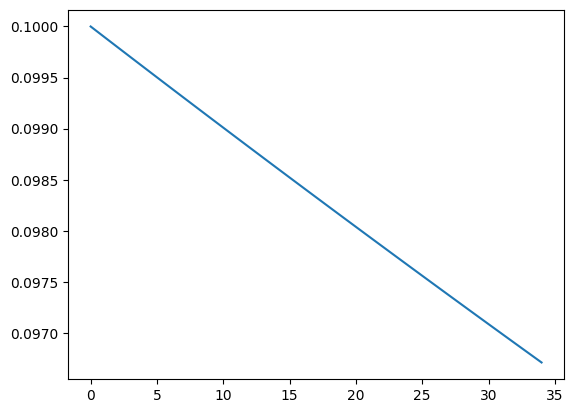

In [ ]:
sns.lineplot(lr.scheduler_progress)
plt.show()

# Plot the loss

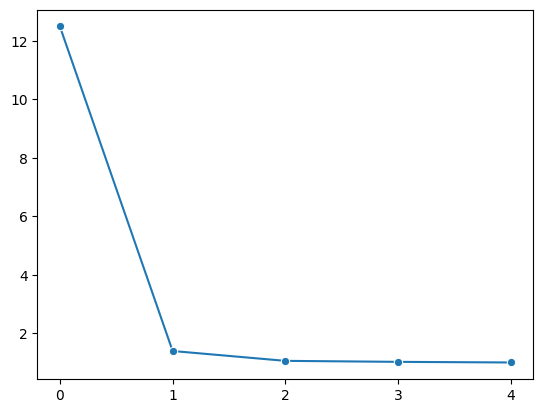

In [ ]:
sns.lineplot(lr.loss_progress, marker='o')
plt.xticks([i for i in range(5)])
plt.show()

# Check the coefficients

In [ ]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)}"
for idx, coeff in enumerate(lr.W[1:, 0]):
  predicted_eq += f" + {jnp.round(coeff, 1)} * X{idx+1}"

print(predicted_eq)

Y_ = 4.599999904632568 + 1.8000000715255737 * X1


# Convex Functions

* In mathematics, a real-valued function is called convex if the line segment between any two distinct points on the graph of the function lies above the graph between the two points.

* Let $X$ be convex subset of real vector space and let $f: X → ℝ$

* Then $f$ is called convex if and only if any of the following equivalent conditions hold:
  * For all $0 \leq t \leq 1$ and $x_1, x_2 \, 𝜖 \, X$
  $$ f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2)$$

* Properties of Convex funtcion:
  * Any local minima is global minima.
  * Where it exists, the hessian(second partial derivate) is positive semi-definite.
  * Sum of two convex function is a convex function.
  * max of two convex functions is a convex function.
  

# California House Price Prediction

In [ ]:
try:
    df = pd.read_csv("./sample_data/california_housing_train.csv") # works in colab
except:
    df = pd.read_csv("/kaggle/input/california-housing-data/california_housing_train.csv") # works in kaggle
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


## Check for null values

In [ ]:
df.isna().sum(axis=0)

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


## Let's plot latitude and longitude with house median values

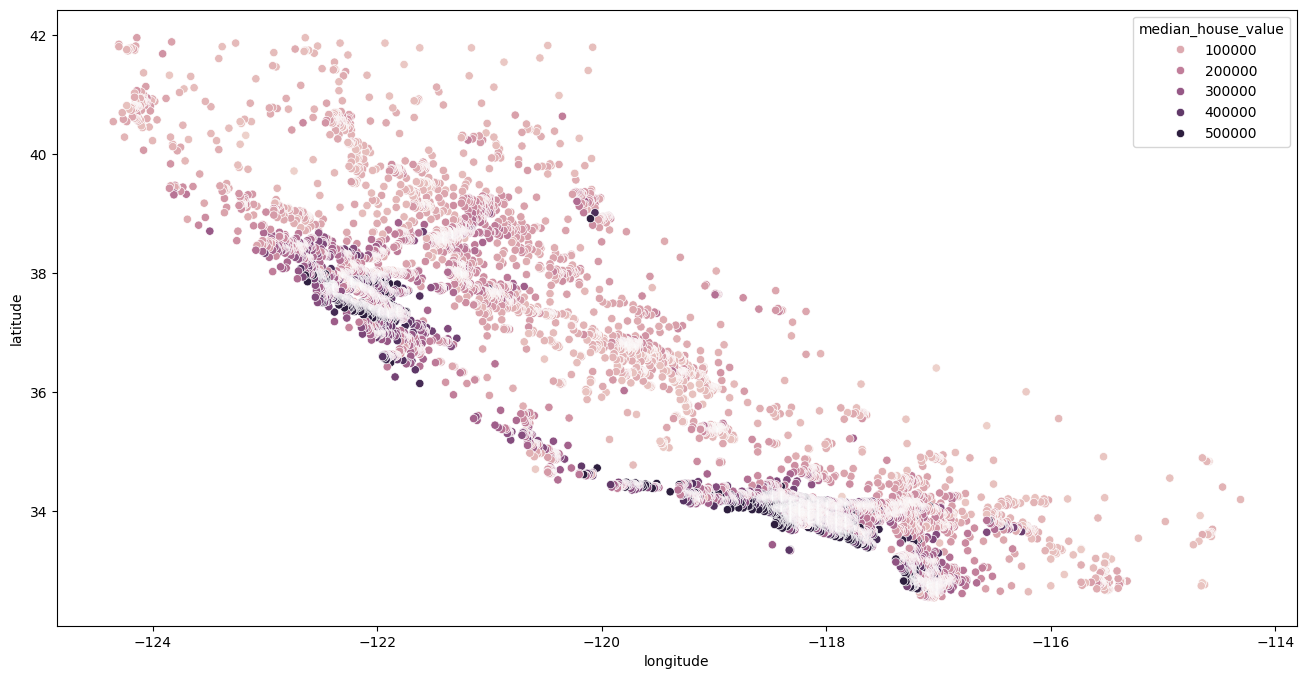

In [ ]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['median_house_value'])
plt.show()

## Let's look at the correlation matrix

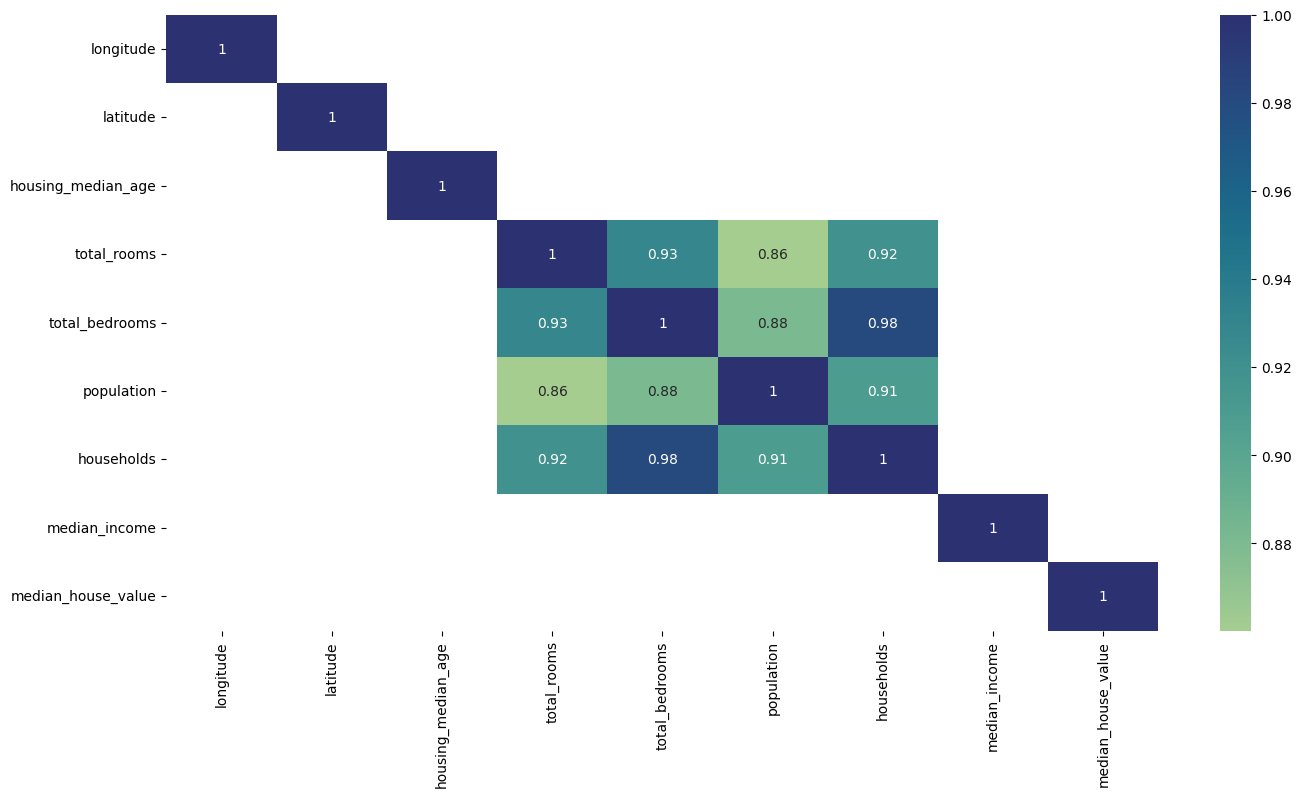

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr()[df.corr() >= 0.7], annot=True, cmap="crest")
plt.show()

## Get feature and target columns

In [ ]:
feature_columns = list(df.drop('median_house_value', axis=1).columns)
target_column = ["median_house_value"]

## Let's split the data to train and validation

In [ ]:
train_df, val_df, train_y, val_y = train_test_split(
    df.drop('median_house_value', axis=1),
    df['median_house_value'],
    random_state=42)

## Pipelines for features and target separately

In [ ]:
features_scaling_pipe = Pipeline(
     steps=[
         ('Standardization', StandardScaler())
     ]
)

target_scaling_pipe = Pipeline(
     steps=[
         ('Standardization', StandardScaler())
     ]
)

## Standardize the data

* Here to observe is that never fit_transform with validation data which will be lekage of the data.

In [ ]:
X_train = features_scaling_pipe.fit_transform(train_df)
y_train = target_scaling_pipe.fit_transform(train_y.values.reshape(-1, 1))

## Train the model using Linear Regression

In [ ]:
# Split key for California housing model
key, california_key = jax.random.split(key)
lr = LinearRegression(california_key, lr=0.1, epochs=10, batch_size=16)

lr.fit(X_train, y_train)

Epoch 1: Loss 0.450243
Epoch 2: Loss 0.395823
Epoch 3: Loss 0.385434
Epoch 4: Loss 0.380606
Epoch 5: Loss 0.377790
Epoch 6: Loss 0.375913
Epoch 7: Loss 0.374548
Epoch 8: Loss 0.373497
Epoch 9: Loss 0.372656
Epoch 10: Loss 0.371963


In [ ]:
X_train.shape[0] // 16

796

## Look how Learning Rate change happened

* Here Number of Training Samples are `12750`.
* Perfect fit if batched using `16` batch size is `12750 // 16` which will be `796` steps in each epoch + `1` epoch for remaining samples left after batching.
* So now we have `(796 + 1) * 10` epoch it will `7970` exact points of learning rates.
* For each batch the learning rate is decayed as per the learning rate schedule
$$ lr = lr_{initial} * \dfrac{1}{1 + decay * steps}$$

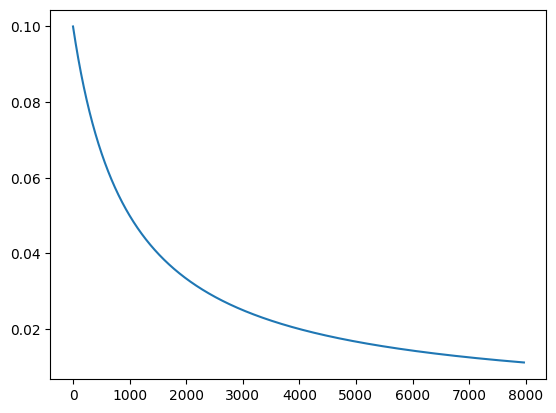

In [ ]:
sns.lineplot(lr.scheduler_progress)
plt.show()

## Plot the loss for each epoch

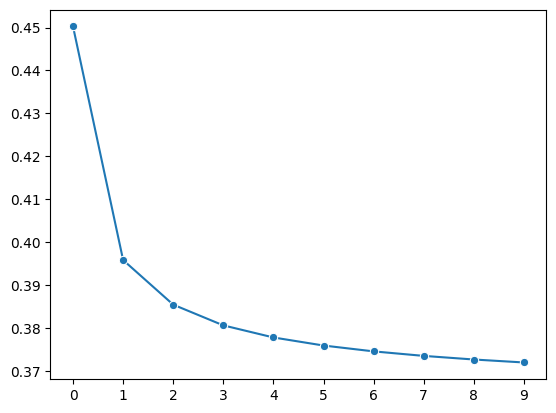

In [ ]:
sns.lineplot(lr.loss_progress, marker='o')
plt.xticks([i for i in range(10)])
plt.show()

## Let's validate the model

In [ ]:
X_val = features_scaling_pipe.transform(val_df)
y_val = target_scaling_pipe.transform(val_y.values.reshape(-1, 1))

In [ ]:
y_val = target_scaling_pipe.inverse_transform(y_val.reshape(-1, 1))
y_pred = target_scaling_pipe.inverse_transform(lr.predict(X_val))

## Check RMSE
$$ MSE = \dfrac{1}{m} \sum_{i=1}^{m} (y^{i}_{pred} - y_{i})^{2} $$
* As MSE will be very high due to high values of the house prices

In [ ]:
print(f"Root Mean Squared Error:{skm.root_mean_squared_error(y_val, y_pred)}")

Root Mean Squared Error:69344.42267519468


### Let's plot upto 50 predictions using seaborn

In [ ]:
idxs = val_df.reset_index(drop=True).index

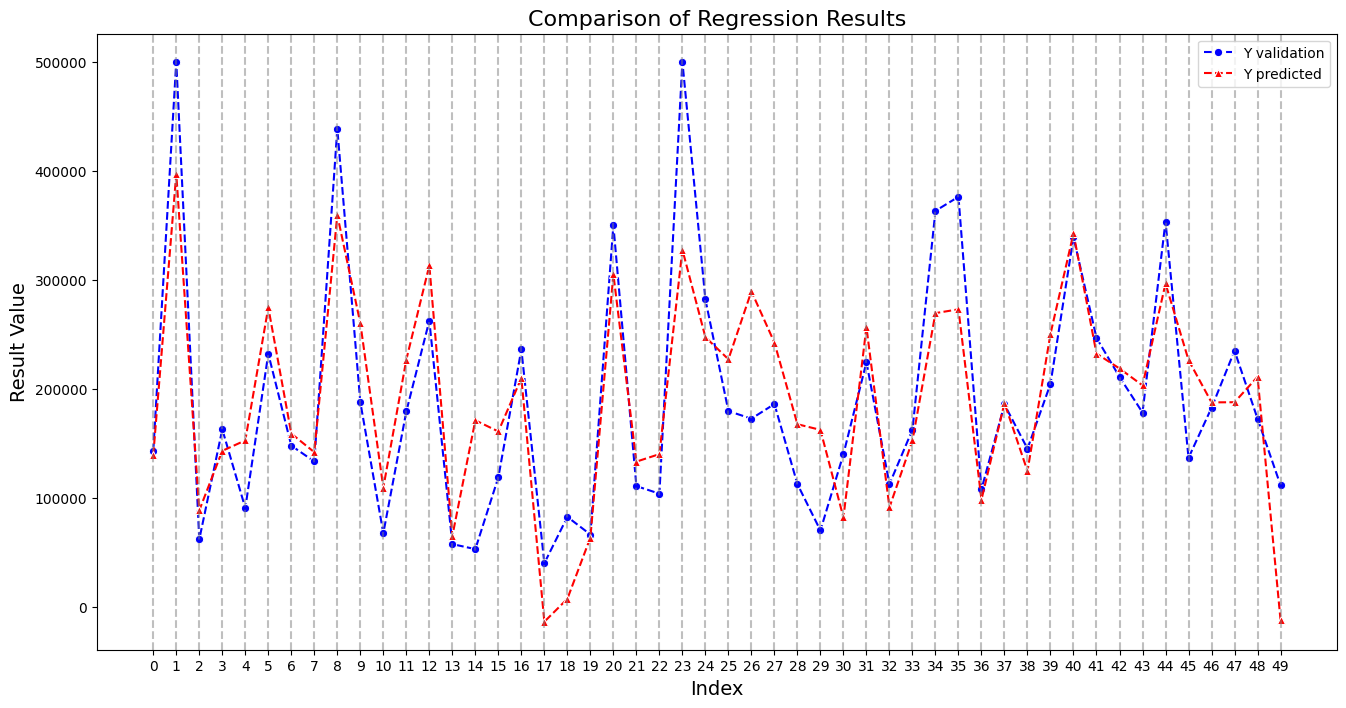

In [ ]:
points = 50

plt.figure(figsize=(16, 8))
ax = sns.lineplot(x=idxs[:points],
                  y=y_val.reshape(-1)[:points],
                  color='b',
                  marker='o',
                  label='Y validation',
                  linestyle='--')
sns.lineplot(x=idxs[:points],
             y=y_pred.reshape(-1)[:points],
             color='r',
             marker='^',
             label='Y predicted',
             linestyle='--')


# Add vertical and horizontal lines
for idx in idxs[:points]:
  ax.axvline(idx, color='gray', linestyle='--', alpha=0.5)


# Add gridlines at each index
ax.set_xticks(idxs[:points])

# Add labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Result Value', fontsize=14)
plt.title('Comparison of Regression Results', fontsize=16)

# Add legend
plt.legend()

plt.show()

## $R$ Squared

* An R-Squared value shows how well the model predicts the outcome of the dependent variable. R-Squared values range from 0 to 1.
* An R-Squared value of 0 means that the model explains or predicts 0% of the relationship between the dependent and independent variables.

In [ ]:
print(f"{skm.r2_score(y_val, y_pred)*100}% of the variance in the dependent variable can be explained by the independent variable(s)")

64.97123948453445% of the variance in the dependent variable can be explained by the independent variable(s)


# Polynomial Regression

* While the Normal Equation can only perform Linear Regression, the Gradient Descent algorithms can be used to train many other models, as we will see.
* Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do).
* This is made possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree.
* For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$, and $ab^2$.

**Note:** PolynomialFeatures`(degree=d)` transforms an array containing `n`
features into an array containing $ \dfrac{(n + d)!}{d!\,n!}$ features, where $n!$ is the factorial of $$, equal to $ 1 × 2 × 3 × ⋯ × n$ . Beware of the combinatorial explosion of the number of features!

In [ ]:
# Split key for polynomial regression data
key, poly_X_key = jax.random.split(key)
m = 1000
X = 6 * jax.random.uniform(poly_X_key, (m, 1)) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

### Plot the data

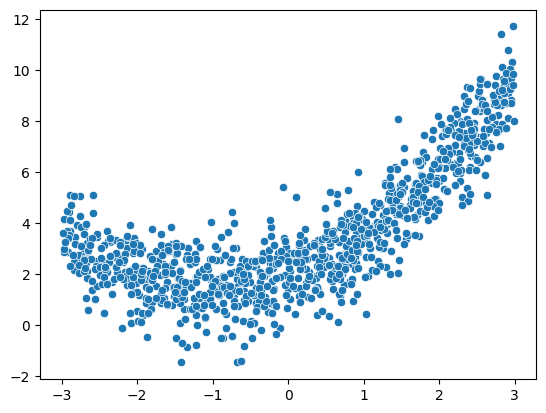

In [ ]:
sns.scatterplot(x=X[:, 0], y=y[:, 0])
plt.show()

### Transform input X to include polynomial are squared data

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

### Let's train the Linear Regression

In [ ]:
# Split key for polynomial model
key, poly_model_key = jax.random.split(key)
lr = LinearRegression(
    key=poly_model_key,
    batch_size=32,
    lr=0.01,
    epochs=25,
)

In [ ]:
lr.fit(X_poly, y)

Epoch 1: Loss 3.320781
Epoch 2: Loss 1.301526
Epoch 3: Loss 1.156749
Epoch 4: Loss 1.088410
Epoch 5: Loss 1.048695
Epoch 6: Loss 1.024842
Epoch 7: Loss 1.010240
Epoch 8: Loss 1.001141
Epoch 9: Loss 0.995366
Epoch 10: Loss 0.991630
Epoch 11: Loss 0.989161
Epoch 12: Loss 0.987492
Epoch 13: Loss 0.986335
Epoch 14: Loss 0.985508
Epoch 15: Loss 0.984900
Epoch 16: Loss 0.984438
Epoch 17: Loss 0.984074
Epoch 18: Loss 0.983779
Epoch 19: Loss 0.983532
Epoch 20: Loss 0.983321
Epoch 21: Loss 0.983134
Epoch 22: Loss 0.982967
Epoch 23: Loss 0.982815
Epoch 24: Loss 0.982674
Epoch 25: Loss 0.982543


### Let's check the fit line

In [ ]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)} + {lr.W[1, 0]} * X + {lr.W[2, 0]} * X^2"
print(predicted_eq)

Y_ = 2.0 + 1.0004366636276245 * X + 0.5106741786003113 * X^2


In [ ]:
y_pred = lr.predict(X_poly)

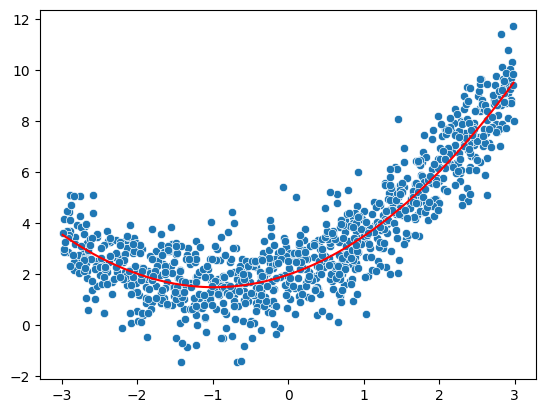

In [ ]:
sns.scatterplot(x=X[:, 0], y=y[:, 0])
sns.lineplot(x=X[:, 0], y=y_pred[:, 0], color="red")
plt.show()

# Ridge Regression
$$ MSE(\theta) = \dfrac{1}{m} * \sum_{i=1}^{m} (\theta^T x^{(i)} - y^{i})^{2} + \dfrac{1}{2}\alpha\sum_{i=1}^{n}\theta_{i}^{2}$$

$$$$
$$ \dfrac{\partial}{\partial \theta_j}MSE(\theta) = \dfrac{2}{m} * \sum_{i=1}^{m} (\theta^Tx^{(i)} - y^{(i)}) \, \, x_{j}^{(i)} + \alpha * \theta $$

$$$$

$$ \theta^{(next \, step)} = \theta - 𝞰\nabla_\theta MSE(\theta) $$
$$$$
* It is important to scale the data (e.g., using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models

In [ ]:
# Split key for ridge regression data
key, ridge_X_key = jax.random.split(key)
X = jax.random.uniform(ridge_X_key, (100, 1))
y = 4 + 3 * X + np.random.randn(100, 1)

### General Linear Regression $\alpha=0$

In [ ]:
# Split key for ridge model with alpha=0
key, ridge_key_0 = jax.random.split(key)
lr = LinearRegression(
    key=ridge_key_0,
    batch_size=32,
    lr=0.1,
    epochs=10,
)
lr.fit(X, y)
y_pred_zero = lr.predict(X)

Epoch 1: Loss 17.408112
Epoch 2: Loss 3.362029
Epoch 3: Loss 1.165947
Epoch 4: Loss 0.824349
Epoch 5: Loss 0.769731
Epoch 6: Loss 0.757828
Epoch 7: Loss 0.751688
Epoch 8: Loss 0.746237
Epoch 9: Loss 0.740999
Epoch 10: Loss 0.736021


In [ ]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)} + {lr.W[1, 0]} * X"
print(predicted_eq)

Y_ = 4.200000286102295 + 2.832625389099121 * X


### Ridge Regression with $\alpha=1$

In [ ]:
# Split key for ridge model with alpha=1
key, ridge_key_1 = jax.random.split(key)
lr = LinearRegression(
    key=ridge_key_1,
    batch_size=32,
    lr=0.1,
    epochs=10,
    ridge_alpha=1
)
lr.fit(X, y)
y_pred_ten = lr.predict(X)

Epoch 1: Loss 15.918461
Epoch 2: Loss 9.701012
Epoch 3: Loss 9.247395
Epoch 4: Loss 9.194409
Epoch 5: Loss 9.184420
Epoch 6: Loss 9.181828
Epoch 7: Loss 9.180868
Epoch 8: Loss 9.180305
Epoch 9: Loss 9.179847
Epoch 10: Loss 9.179418


In [ ]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)} + {lr.W[1, 0]} * X"
print(predicted_eq)

Y_ = 2.799999952316284 + 1.6689790487289429 * X


### Ridge Regression with $\alpha=10$

In [ ]:
# Split key for ridge model with alpha=10
key, ridge_key_10 = jax.random.split(key)
lr = LinearRegression(
    key=ridge_key_10,
    batch_size=32,
    lr=0.1,
    epochs=10,
    ridge_alpha=10
)
lr.fit(X, y)
y_pred_hundred = lr.predict(X)

Epoch 1: Loss 24.724314
Epoch 2: Loss 22.815701
Epoch 3: Loss 22.802641
Epoch 4: Loss 22.790731
Epoch 5: Loss 22.779129
Epoch 6: Loss 22.767820
Epoch 7: Loss 22.756798
Epoch 8: Loss 22.746044
Epoch 9: Loss 22.735556
Epoch 10: Loss 22.725323


In [ ]:
predicted_eq = f"Y_ = {jnp.round(lr.W[0, 0], 1)} + {lr.W[1, 0]} * X"
print(predicted_eq)

Y_ = 0.20000000298023224 + 0.12593987584114075 * X


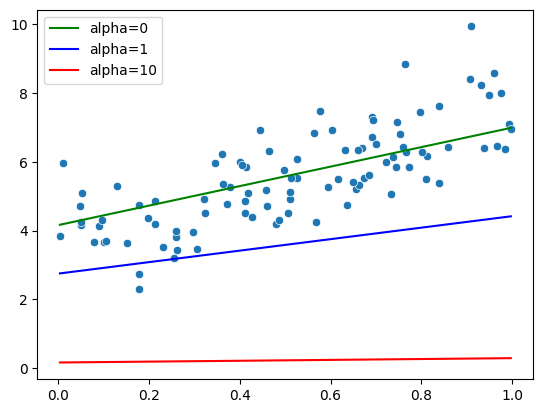

In [ ]:
sns.scatterplot(x=X[:, 0], y=y[:, 0])
sns.lineplot(x=X[:, 0], y=y_pred_zero[:, 0], color="green", label="alpha=0")
sns.lineplot(x=X[:, 0], y=y_pred_ten[:, 0], color="blue", label="alpha=1")
sns.lineplot(x=X[:, 0], y=y_pred_hundred[:, 0], color="red", label="alpha=10")
plt.legend()
plt.show()

# References:
1. [Math Differential Calculus](https://colab.research.google.com/github/ageron/handson-ml2/blob/master/math_differential_calculus.ipynb#scrollTo=nwzF_EXtqqe1)

2. [Hands-On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975/ref=asc_df_1098125975/?tag=hyprod-20&linkCode=df0&hvadid=564681728094&hvpos=&hvnetw=g&hvrand=12536021134787862812&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9061321&hvtargid=pla-1651497364252&psc=1&mcid=ee20b34166b93f94b9a88a727e2204b3&gclid=CjwKCAjwt-OwBhBnEiwAgwzrUvy6fyRVoCj9LZC1E4kgyL5KvZKoFNJFSWa2nRThyPByYb_YQCTPERoCVQsQAvD_BwE)

3. [ML Exercises](https://gist.github.com/byelipk/345ee92c42f579a9dc1938b0bb86be2e)
